**Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [19]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install sacrebleu
# !pip install rouge_score
# !pip install py7zr
import torch
import nltk
# nltk.download('punkt')
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from datasets import load_dataset
from datasets import load_metric
from transformers import pipeline
from transformers import set_seed
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import Trainer
from transformers import TrainingArguments

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**The CNN/DailyMail Dataset**
- This dataset consists of around 300,000 pairs of news articles and their corresponding summaries, composed from the bullet points that CNN and DailyMail attach to their articles.

In [ ]:
#@ LOADING THE DATASET:
dataset = load_dataset("cnn_dailymail", version="3.0.0")               # Loading the dataset.
print(f"Features: {dataset['train'].column_names}")                    # Inspecting columns.

Using custom data configuration default
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [ ]:
#@ INSPECTING SAMPLE ARTICLES:
sample = dataset["train"][1]                                    # Initialization.
print(f"Article (excerpt of 500 characters, total length:\
{len(sample['article'])})")                                     # Inspecting number of characters.
print(sample["article"][:500])                                  # Inspecting article.
print(f"\nSummary length: {len(sample['highlights'])}")         # Inspecting length of summary.
print(sample["highlights"])                                     # Inspecting summary.

Article (excerpt of 500 characters, total length:3192)
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n

Summary length: 180
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


**Text Summarization Pipelines**

In [ ]:
#@ INITIALIZING TEXT SUMMARIZATION:
sample_text = dataset["train"][1]["article"][:2000]             # Initialization.
summaries = {}                                                  # Initializing a dictionary.

#@ SENTENCE TOKENIZATON: EXAMPLE:
string = "The U.S. are a country. The U.N. is an organization." # Text example.
sent_tokenize(string)                                           # Inspection.

['The U.S. are a country.', 'The U.N. is an organization.']

In [5]:
#@ INITIALIZING SUMMARIZATION BASELINE:
def three_sentence_summary(text):                               # Defining function.
    return "\n".join(sent_tokenize(text)[:3])                   # Getting 3 sentences.
summaries["baseline"] = three_sentence_summary(sample_text)     # Getting baseline summary.

**GPT-2**

In [ ]:
#@ INITIALIZING SUMMARIZATION WITH GPT-2:
set_seed(2022)
pipe = pipeline("text-generation", model="gpt2")                # Initializing pipeline.
gpt2_query = sample_text + "\nTL;DR:\n"                         # Initialization.
pipe_out = pipe(gpt2_query, max_length=512, 
                clean_up_tokenization_spaces=True)              # Generating summaries.
summaries["gpt2"] = "\n".join(sent_tokenize(
    pipe_out[0]["generated_text"][len(gpt2_query):]
))                                                              # Adding to summaries.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**T5**

In [ ]:
#@ INITIALIZING SUMMARIZATION WITH T5:
pipe = pipeline("summarization", model="t5-small")              # Initializing T5 pipeline.
pipe_out = pipe(sample_text)                                    # Generating summaries.
summaries["t5"] = "\n".join(sent_tokenize(
    pipe_out[0]["summary_text"]
))                                                              # Adding to summaries.

**BART**

In [ ]:
#@ IMPLEMENTATION OF BART:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")   # Initializing BART pipeline.
pipe_out = pipe(sample_text)                                        # Generating summaries.
summaries["bart"] = "\n".join(sent_tokenize(
    pipe_out[0]["summary_text"]
))                                                                  # Adding to summaries.

**PEGASUS**

In [ ]:
#@ INITIALIZING SUMMARIZATION WITH PEGASUS:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")      # Initializing pegasus pipeline.
pipe_out = pipe(sample_text)                                                # Generating summaries.
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")  # Adding to summaries.

**Comparing Different Summaries**

In [ ]:
#@ COMPARING DIFFERENT MODEL SUMMARIES: 
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])                 # Initializing baseline summaries.
print(" ")

for model_name in summaries:
    print(model_name.upper())                            # Initializing model name.
    print(summaries[model_name])                         # Getting summaries. 
    print(" ")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .
 
BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.
 
GPT2
United States Team
 
T5
usain Bolt wins men's 4x100m relay gold in Moscow .
the fastest man in the world wins in 37.36 seconds .
canada takes bronze after being disqualified for a faulty handover .
 
BART
Usain Bolt wins his third gold of the world championships in Moscow.
Bolt anchors Jamaica to victory in the m

**Quality Measurement**

In [ ]:
#@ INITIALIZING QUALITY MEASUREMENT: EXAMPLE: 
bleu_metric = load_metric("sacrebleu")                                  # Initializing BLEU.
bleu_metric.add(prediction="the the the the the the",
                reference=["the cat is on the mat"])                    # Initializing example.
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)    # Computing bleu score. 
results["precisions"] = [np.round(p, 2) for p in results["precisions"]] # Adding arrays of precisions.
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])      # Creating a dataframe.

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [ ]:
#@ INITIALIZING QUALITY MEASUREMENT: EXAMPLE: 
bleu_metric = load_metric("sacrebleu")                                  # Initializing BLEU.
bleu_metric.add(prediction="the cat is on mat",
                reference=["the cat is on the mat"])                    # Initializing example.
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)    # Computing bleu score. 
results["precisions"] = [np.round(p, 2) for p in results["precisions"]] # Adding arrays of precisions.
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])      # Creating a dataframe.

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


**ROUGE**

In [ ]:
#@ INITIALIZING QUALITY MEASUREMENT: ROUGE:
rouge_metric = load_metric("rouge")                                         # Initializing rouge metric. 
reference = dataset["train"][1]["highlights"]                               # Initializing reference summary. 
records = []                                                                # Initialization.
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]                   # Initialization.
for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], 
                     reference=reference)                                   # Adding predicted summaries.
    score = rouge_metric.compute()                                          # Computing scores.
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)                                              # Adding to records.
pd.DataFrame.from_records(records, index=summaries.keys())

**PEGASUS EVALUATION**

In [6]:
#@ FUNCTION FOR PEGASUS EVALUATION: BASELINE SUMMARIES:
def evaluate_summaries_baseline(dataset, metric, column_text="article",
                                column_summary="highlights"):                           # Defining function. 
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]         # Initializing baseline summary.
    metric.add_batch(predictions=summaries, references=dataset[column_summary])         # Adding to metric.
    score = metric.compute()                                                            # Computing rouge scores.
    return score 

#@ IMPLEMENTATION OF FUNCTION:
test_sampled = dataset["test"].shuffle(seed=2022).select(range(1000))                   # Generating 1000 samples.
score = evaluate_summaries_baseline(test_sampled, rouge_metric)                         # Implementation of function. 
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T              # Creating a dataframe.

In [7]:
#@ FUNCTION FOR PEGASUS EVALUATION: 
device = "cuda" if torch.cuda.is_available() else "cpu"                                 # Initializing gpu.
def chunks(list_of_elements, batch_size):                                               # Defining function.
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i:i + batch_size]                                        # Getting chunks of data.

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16,device=device,column_text="article",
                               column_summary="highlights"):                            # Defining function.
    article_batches = list(chunks(dataset[column_text], batch_size))                    # Initializing chunks of dataset.
    target_batches = list(chunks(dataset[column_summary], batch_size))                  # Initializing chunks of summaries.
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                           padding="max_length", return_tensors="pt")                   # Getting tokenized tensors.
        summaries = model.generate(input_ids=inputs["input_ids"].to(device), 
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)     # Generating summaries.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                              clean_up_tokenization_spaces=True) for s 
                             in summaries]                                              # Decoding summaries.
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]          # Decoding summaries.
        metric.add_batch(predictions=decoded_summaries, 
                         references=target_batch)                                       # Adding to metric.
    score = metric.compute()                                                            # Computing scores.
    return score

In [ ]:
#@ INITIALIZING PEGASUS EVALUATION:
model_ckpt = "google/pegasus-cnn_dailymail"                             # Initializing model checkpoint.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)                   # Initializing pretrained tokenizer.
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)    # Initializing pretrained model.
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, 
                                   tokenizer, batch_size=8)             # Generating rouge scores.
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)   # Creating dictionary of rouge scores.
pd.DataFrame(rouge_dict, index=["pegasus"])                             # Creating a dataframe.

**TRAINING SUMMARIZATION MODEL**

In [9]:
#@ LOADING SAMSUM DATASET:
dataset_samsum = load_dataset("samsum")                                         # Loading samsum dataset.
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]        # Inspecting splits.
print(f"Split lengths: {split_lengths}")                                        # Inspecting dataset splits.
print(f"Features: {dataset_samsum['train'].column_names}")                      # Inspecting column names.
print("\nDialogue: ")                                                           # Initialization.
print(dataset_samsum["test"][0]["dialogue"])                                    # Inspecting dialogue.
print("\nSummary: ")
print(dataset_samsum["test"][0]["summary"])                                     # Inspecting summary. 

Reusing dataset samsum (/root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6)


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue: 
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary: 
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


**PEGASUS ON SAMSUM**

In [12]:
#@ PROCESSING THE SAMSUM:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")      # Initializing pegasus pipeline.
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])                      # Implementation of pegaus.
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))                  # Inspecting summary.

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [13]:
#@ INITIALIZING ROUGE EVALUATION ON SAMSUM:
rouge_metric = load_metric("rouge")                                             # Initializing rouge metric. 
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]                       # Initialization.
model_ckpt = "google/pegasus-cnn_dailymail"                                     # Initializing model checkpoint.
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)                           # Initializing pretrained tokenizer.
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)            # Initializing pretrained model.
score = evaluate_summaries_pegasus(dataset_samsum["test"], 
                                   metric=rouge_metric, model=model,
                                   tokenizer=tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)      # Getting rouge scores.
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)           # Creating dictionary of rouge scores.
pd.DataFrame(rouge_dict, index=["pegasus"])                                     # Creating a dataframe.

**Fine-Tuning PEGASUS**

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


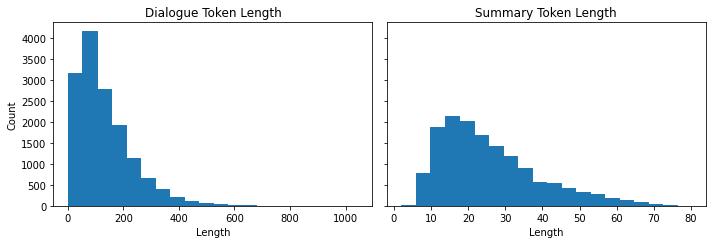

In [15]:
#@ INSPECTING LENGTH DISTRIBUTIONS:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]         # Initialization. 
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]          # Initialization.
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)                            # Initialization.
ax[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
ax[0].set_title("Dialogue Token Length")
ax[0].set_xlabel("Length")
ax[0].set_ylabel("Count")
ax[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
ax[1].set_title("Summary Token Length")
ax[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [17]:
#@ PREPARING FEATURES FOR TRAINING:
def convert_examples_to_features(example_batch):                                                # Defining function. 
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)    # Initializing input encodings. 
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True) # Initializing target encodings.
    return {"input_ids": input_encodings["input_ids"], 
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}                                            # Getting features. 

#@ IMPLEMENTATION OF FUNCTION:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)              # Creating features.
columns = ["input_ids", "labels", "attention_mask"]                                             # Initialization. 
dataset_samsum_pt.set_format(type="torch", columns=columns)                                     # Converting into tensors.

  0%|          | 0/15 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6/cache-3e18876e9d29eeb4.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6/cache-932d8526eef7d100.arrow


In [ ]:
#@ FINE-TUNING THE PEGASUS MODEL:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)                          # Initializing data collator.
training_args = TrainingArguments(output_dir="pegasus-samsum", num_train_epochs=1, 
                                  warmup_steps=500, per_device_train_batch_size=1, 
                                  per_device_eval_batch_size=1, weight_decay=0.01, 
                                  logging_steps=10, push_to_hub=False, 
                                  evaluation_strategy="steps", eval_steps=500, 
                                  save_steps=1e6, gradient_accumulation_steps=16)               # Initializing training arguments.
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, 
                  data_collator=seq2seq_data_collator, 
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])                                 # Initializing trainer.
trainer.train()

#@ INITIALIZING ROUGE EVALUATION ON SAMSUM:
score = evaluate_summaries_pegasus(dataset_samsum["test"], 
                                   metric=rouge_metric, model=trainer.model,
                                   tokenizer=tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=2)      # Getting rouge scores.
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)           # Creating dictionary of rouge scores.
pd.DataFrame(rouge_dict, index=["pegasus"])                                     # Creating a dataframe.

In [ ]:
#@ GENERATING DIALOGUE SUMMARIES:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}         # Initialization.
sample_text = dataset_samsum["test"][0]["dialogue"]                             # Initalizing sample text.
reference = dataset_samsum["test"][0]["summary"]                                # Initializing reference summary.
pipe = pipeline("summarization", model="./pegasus-samsum")                      # Initializing pipeline.
print("\nDialogue:")
print(sample_text)                                                              # Initializing dialogue.
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])                       # Inspection.